In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib.colors import ListedColormap
from statistics import mean
import seaborn as sns
import itertools
import math
df= pd.read_csv(r'/home/jovyan/creditcard.csv.zip',engine='python')
df = df.round(decimals=2)

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

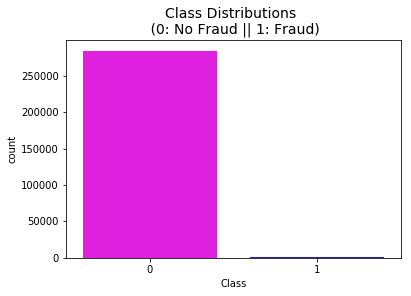

In [5]:
colors = ["magenta", "blue"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

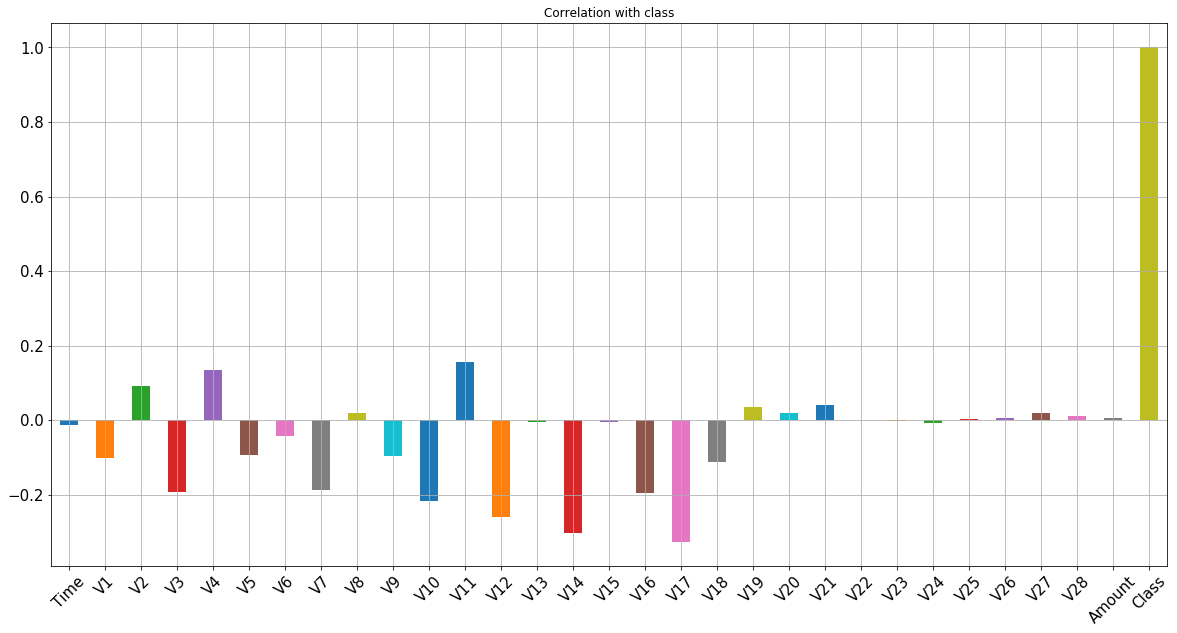

In [6]:
df.corrwith(df.Class).plot.bar(
        figsize = (20, 10), title = "Correlation with class", fontsize = 15,rot = 45, grid = True)

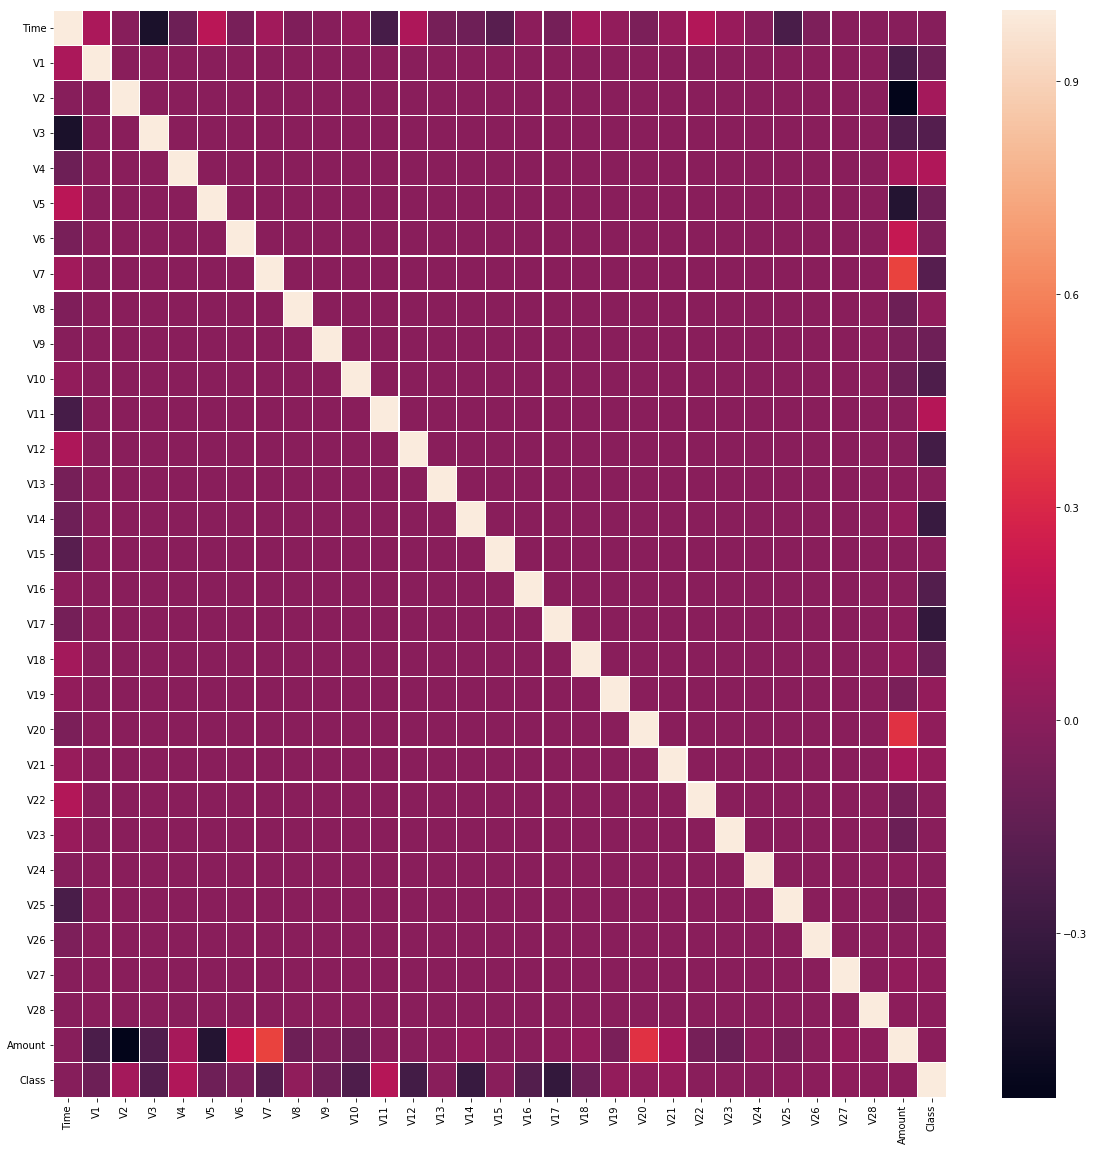

In [7]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(20,20))        
sns.heatmap(corr, linewidths=.2, ax=ax)

In [8]:
def train_test_equal_split(df):
    """Takes dataframe as an input.
        returns X_train,X_test,y_train,y_test as dataframes.
        The ratio of fraud obs to geniune obs are equal in both 
        train and test sets""" 
    X,y=df.drop(['Class'],axis=1),df['Class']
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
    for train_index, test_index in sss.split(X, y):
        X_train,X_test=X.iloc[train_index],X.iloc[test_index]
        y_train,y_test=y.iloc[train_index],y.iloc[test_index]    
    return X_train,X_test,y_train,y_test

def train_validation_equal_split(X_train,y_train):
    D1,D2,D3=[],[],[]
    K,L=[],[]
    skf = StratifiedKFold(n_splits=3, random_state=0)
    for train_index, val_index in skf.split(X_train,y_train):
        K.append([X_train.iloc[train_index],X_train.iloc[val_index]])
        L.append([y_train.iloc[train_index],y_train.iloc[val_index]])
    D1.append([K[0][0],K[0][1],L[0][0],L[0][1]])
    D2.append([K[1][0],K[1][1],L[1][0],L[1][1]])
    D3.append([K[2][0],K[2][1],L[2][0],L[2][1]])
    return D1,D2,D3

def unpack(D):
    X_train_proper,X_val,y_train_proper,y_val=D[0][0],D[0][1],D[0][2],D[0][3]
    return X_train_proper,X_val,y_train_proper,y_val

def scale_val(X_train,X_other):
    X_train_ind,X_other_ind=X_train.index,X_other.index
    col=X_train.columns
    X_train_subset=X_train.drop(['Amount', 'Time'],axis=1)
    X_other_subset=X_other.drop(['Amount', 'Time'],axis=1)
    sc=StandardScaler()
    std_scale = sc.fit(X_train[['Amount', 'Time']])
    X_train_time_amount_scaled=std_scale.transform(X_train[['Amount', 'Time']])
    X_other_time_amount_scaled=std_scale.transform(X_other[['Amount', 'Time']])
    scaled_X_train=np.concatenate((X_train_time_amount_scaled, X_train_subset), axis=1)
    scaled_X_other=np.concatenate((X_other_time_amount_scaled, X_other_subset), axis=1)
    scaled_X_train_df=pd.DataFrame(scaled_X_train,index=X_train_ind,columns=col)
    scaled_X_other_df=pd.DataFrame(scaled_X_other,index=X_other_ind,columns=col)
    
    return scaled_X_train_df,scaled_X_other_df

def getting_Fraud_Genuine_subsets(X_train_scaled,y_train):
    """Split train set into fraud and geniune dataframes"""
    #Merge train and labels
    Train=pd.concat([X_train_scaled,y_train],axis=1)

    #Select Fraud and Geniune cases
    Fraud_Train=Train[Train.Class==1]
    Geniune_Train=Train[Train.Class==0]

    #drop 'Class' column
    fraud_Train=Fraud_Train.drop(['Class'],axis=1)
    geniune_Train=Geniune_Train.drop(['Class'],axis=1)
    
    return fraud_Train,geniune_Train

def first_stage(Fraud_Train,Geniune_Train,F_cluster,G_cluster):
    
    kmeans_Fraud= KMeans(n_clusters=F_cluster, random_state=0).fit(Fraud_Train)
    Fraud_centers,Fraud_labels=kmeans_Fraud.cluster_centers_,kmeans_Fraud.labels_

    kmeans_Geniune= KMeans(n_clusters=G_cluster, random_state=0).fit(Geniune_Train)
    Geniune_centers,Geniune_labels=kmeans_Geniune.cluster_centers_,kmeans_Geniune.labels_+(len(Fraud_centers))

    centers=np.concatenate((Fraud_centers,Geniune_centers),axis=0)
    labels=np.concatenate((Fraud_labels,Geniune_labels),axis=0)
    
    #set up "centers_labels_df"
    #center:cluster centers, labels:cluster_no
    d={'centers':list(centers)}
    d['cluster_no']=[0 for i in range(len(centers))]
    centers_labels_df=pd.DataFrame(d)
    for i in range(len(centers_labels_df)):
        if i<len(Fraud_centers):
            centers_labels_df.iloc[i,1]=kmeans_Fraud.predict(np.array(d['centers'][i]).reshape(1,-1))
        else:
            centers_labels_df.iloc[i,1]=kmeans_Geniune.predict(np.array(d['centers'][i]).reshape(1,-1))+(len(Fraud_centers))
            
    ###############################################################################################
    #set up "points_labels_df"
    #points:all the data points, labels(cluster_no):cluster oints belong
    Train_Set=Fraud_Train.append(Geniune_Train)
    Train_Set_columns=Train_Set.columns
    labels_df=pd.DataFrame(labels,columns=['cluster_no'])
    labels_df.index=Train_Set.index
    points_labels_df=pd.concat([Train_Set,labels_df],axis=1)
    #replcaing points as list of cordinated
    points=[]
    for i in range(len(points_labels_df)):
        points.append([points_labels_df.iloc[i,j] for j in range(points_labels_df.shape[1]-1)])
    points_labels_df['point']=points
    points_labels_df['real_index']=points_labels_df.index
    
    #Removing single attribute columns
    points_labels_df=points_labels_df.drop(Train_Set_columns,axis=1)
    #Merging "points_labels_df" and "centers_labels_df" dataframes
    point_center_labels_df=pd.merge(points_labels_df, centers_labels_df)
    
    #Addind "dist_center" column
    dist_to_center=[]
    for i in range(len(point_center_labels_df)):
        itself=point_center_labels_df.iloc[i,1]
        its_center=point_center_labels_df.iloc[i,3]
        dist_to_center.append(np.linalg.norm((its_center-itself),ord=2))
    point_center_labels_df['dist_to_center']=dist_to_center
    ###############################################################################################
    
    centers_labels_betas_dist_df=centers_labels_df.copy(deep=True)
    centers_labels_betas_same_df=centers_labels_df.copy(deep=True)
    
    label_list,count_list=np.unique(point_center_labels_df.cluster_no,return_counts=True)
    sigma_distinct,beta_distinct=np.zeros(len(label_list)),np.zeros(len(label_list))
    for label,co in zip(label_list,count_list):
        s=np.sum(point_center_labels_df[point_center_labels_df.cluster_no==label]['dist_to_center'])
        sigma_distinct[label]=s/co
        if sigma_distinct[label]==0:
            print('sigma for ',label,'th sigma is 0')
            sigma_distinct[label]=.001
            beta_distinct[label]=1/(2*(sigma_distinct[label]**2))
        else:
            beta_distinct[label]=1/(2*(sigma_distinct[label]**2))
        
    #FOR SAME BETA
    list_of_difference=[]
    for center0, center1 in itertools.combinations(centers, 2):
        list_of_difference.append(np.linalg.norm((center0-center1),ord=2))
    max_difference=max(list_of_difference)
    sigma_same=np.ones(len(label_list))*(max_difference/(math.sqrt(2*len(label_list))))
    beta_same=1/(2*(sigma_same**2))

    centers_labels_betas_dist_df['DBeta']=beta_distinct
    centers_labels_betas_same_df['Beta']=beta_same
    
    return centers_labels_betas_dist_df,centers_labels_betas_same_df

def get_activation_output_values(centers_labels_beta_df,X_dataset):
    
    X_dataset_np=X_dataset.as_matrix().reshape(X_dataset.shape)
    
    def activation_function(beta_point,center_point,x_point):
        return np.exp(-beta_point*(np.sum((x_point-center_point)**2)))
    
    #Outputs when betas are distinct
    activation_output=np.zeros((len(X_dataset),len(centers_labels_beta_df)+1))
    for i in range(len(X_dataset)):
        for j in range(len(centers_labels_beta_df)):
            activation_output[i][j]=activation_function(centers_labels_beta_df.iloc[j,2],
                                                         centers_labels_beta_df.iloc[j,0],X_dataset_np[i,:])
        
    bias=np.ones(len(activation_output))
    activation_output[:,0]=bias
    
    return activation_output


def get_weights(activation_outputs,y_train):
    #convert y_train to numpy array
    y_train_np=y_train.values
    #Convert to onehot_encoded version
    onehot_encoder = OneHotEncoder(sparse=False)
    y_train_np = y_train_np.reshape(len(y_train_np), 1)
    y_train_onehot_encoded = onehot_encoder.fit_transform(y_train_np)

    #Find pseudinverse of activation values
    activation_outputs_pseu=np.linalg.pinv(activation_outputs)
    
    #Find the W 
    W=np.matmul(activation_outputs_pseu,y_train_onehot_encoded)
    Geniuni_weights,Fraud_weights=W[:,0],W[:,1]
    
    return Geniuni_weights,Fraud_weights

def get_score(activation_output,Geniune_weights,Fraud_weights,y_dataset):
    Geniune_scores=np.matmul(activation_output,Geniune_weights)
    fraud_scores=np.matmul(activation_output,Fraud_weights)
    y_hat=np.zeros(len(y_dataset))
    for i in range(len(y_dataset)):
        if Geniune_scores[i]>fraud_scores[i]:
            y_hat[i]=0
        elif Geniune_scores[i]<=fraud_scores[i]:
            y_hat[i]=1
    y_train_np=y_dataset.values
    TN, FP, FN, TP = confusion_matrix(y_train_np,y_hat).ravel()
    Precision=TP/(TP+FP)
    Recall=TP/(TP+FN)
    F1=(2*TP)/(2*TP+FP+FN)
    return Precision,Recall,F1

In [9]:
def get_results(Fraud_Train,Geniune_Train,Fraud_cluster_no,Geniune_cluster_no,scaled_X_train_df,scaled_X_val_df,y_train,y_val):
    
    L,c1,c2=[],[],[]
    P_test_dist_beta,R_test_dist_beta,F1_test_dist_beta=[],[],[]
    p_test_same_beta,r_test_same_beta,f1_test_same_beta=[],[],[]
    
    
    for combination in itertools.product(Fraud_cluster_no, Geniune_cluster_no):
        L.append(combination)
    for item in L:
        c1.append(item[0])
        c2.append(item[1])
        centers_labels_betas_dist_df,centers_labels_betas_same_df=first_stage(Fraud_Train,Geniune_Train,item[0],item[1])
    
        #when betas are different for all hidden neurons
        activation_output_train=get_activation_output_values(centers_labels_betas_dist_df,scaled_X_train_df)
        activation_output_test=get_activation_output_values(centers_labels_betas_dist_df,scaled_X_val_df)
        Geniune_weight,Fraud_weight=get_weights(activation_output_train,y_train)
        
        P_Te,R_Te,F1_Te=get_score(activation_output_test,Geniune_weight,Fraud_weight,y_val)
        
        P_test_dist_beta.append(P_Te)
        R_test_dist_beta.append(R_Te)
        F1_test_dist_beta.append(F1_Te)
    
    
        #when betas are the same for all hidden neurons
        activation_output_test=get_activation_output_values(centers_labels_betas_same_df,scaled_X_val_df)
        Geniune_weight,Fraud_weight=get_weights(activation_output_train,y_train)
        p_T,r_T,f1_T=get_score(activation_output_train,Geniune_weight,Fraud_weight,y_train)
        p_Te,r_Te,f1_Te=get_score(activation_output_test,Geniune_weight,Fraud_weight,y_val)

        p_test_same_beta.append(p_Te)
        r_test_same_beta.append(r_Te)
        f1_test_same_beta.append(f1_Te)
        
        #creating dataframe
    dic={'c1':c1,
         'c2':c2,
         'Precision_Te_dist_beta':P_test_dist_beta,
         'Recall_Te_dist_beta':R_test_dist_beta,
         'F1_Te_dist_beta':F1_test_dist_beta,
         'Precision_Te_same_beta':p_test_same_beta,
         'Recall_Te_same_beta':r_test_same_beta,
         'F1_Te_same_beta':f1_test_same_beta}
    D=pd.DataFrame(dic,index=L)
    
    return D.T

## 1) Training and cross-validation of RBFN

In [ ]:
X_train,X_test,y_train,y_test=train_test_equal_split(df)
D1,D2,D3=train_validation_equal_split(X_train,y_train)
X_train_proper1,X_val1,y_train_proper1,y_val1=unpack(D1)
X_train_proper2,X_val2,y_train_proper2,y_val2=unpack(D2)
X_train_proper3,X_val3,y_train_proper3,y_val3=unpack(D3)
################################################
#SCALING
s_X_train1,s_X_val1=scale_val(X_train_proper1,X_val1)
s_X_train2,s_X_val2=scale_val(X_train_proper2,X_val2)
s_X_train3,s_X_val3=scale_val(X_train_proper3,X_val3)
####################################################

df1=get_results([10,15,20,25,30,35,40],[30,40,50,60,70,80,90,100],s_X_train1,s_X_val1,y_train_proper1,y_val1)
###########
df2=get_results([10,15,20,25,30,35,40],[30,40,50,60,70,80,90,100],s_X_train2,s_X_val2,y_train_proper2,y_val2)
######################################
df3=get_results([10,15,20,25,30,35,40],[30,40,50,60,70,80,90,100],s_X_train3,s_X_val3,y_train_proper3,y_val3)

## 2) Testing on test set

In [12]:
## Different Type RBFN with (10,90) combination of Hyperparameters
X_train,X_test,y_train,y_test=train_test_equal_split(df)
s_X_train,s_X_test=scale_val(X_train,X_test)
fraud_Train,geniune_Train=getting_Fraud_Genuine_subsets(s_X_train,y_train)
centers_labels_betas_dist_df,centers_labels_betas_same_df=first_stage(fraud_Train,geniune_Train,10,90)
activation_output_train=get_activation_output_values(centers_labels_betas_dist_df,s_X_train)
Geniune_weights,Fraud_weights=get_weights(activation_output_train,y_train)
activation_output_test=get_activation_output_values(centers_labels_betas_dist_df,s_X_test)
Geniune_scores_=np.matmul(activation_output_test,Geniune_weights)
fraud_scores_=np.matmul(activation_output_test,Fraud_weights)
y_hat=np.zeros(len(y_test))
for i in range(len(y_test)):
    if Geniune_scores_[i]>fraud_scores_[i]:
        y_hat[i]=0
    elif Geniune_scores_[i]<=fraud_scores_[i]:
        y_hat[i]=1
y_train_np=y_test.values
TNd, FPd, FNd, TPd = confusion_matrix(y_train_np,y_hat).ravel()
Precisiond=TPd/(TPd+FPd)
Recalld=TPd/(TPd+FNd)
F1d=(2*TPd)/(2*TPd+FPd+FNd)
############################
## Same Type RBFN with (15,90) combination of Hyperparameters
fraud_Train,geniune_Train=getting_Fraud_Genuine_subsets(s_X_train,y_train)
centers_labels_betas_dist_df,centers_labels_betas_same_df=first_stage(fraud_Train,geniune_Train,15,90)
activation_output_train=get_activation_output_values(centers_labels_betas_dist_df,s_X_train)
Geniune_weights,Fraud_weights=get_weights(activation_output_train,y_train)
activation_output_test=get_activation_output_values(centers_labels_betas_same_df,s_X_test)
Geniune_scores=np.matmul(activation_output_test,Geniune_weights)
fraud_scores=np.matmul(activation_output_test,Fraud_weights)
y_hat=np.zeros(len(y_test))
for i in range(len(y_test)):
    if Geniune_scores[i]>fraud_scores[i]:
        y_hat[i]=0
    elif Geniune_scores[i]<=fraud_scores[i]:
        y_hat[i]=1
y_train_np=y_test.values
TNs, FPs, FNs, TPs = confusion_matrix(y_train_np,y_hat).ravel()
Precisions=TPs/(TPs+FPs)
Recalls=TPs/(TPs+FNs)
F1s=(2*TPs)/(2*TPs+FPs+FNs)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:141: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:141: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:141: FutureWarning: Method .as_matrix will be